# Part 6a: Control a Marble with Reinforcement Learning

Fawad Ahmad

## Overview

In this part we will consider the area of friction. For that i have considered following points.
* The area of friction will cause speed of the marble to decrease. 
* The area of friction will decrease the distance too as it has reduced the speed.
* This time i am considering the increase in velocity of the marble when it passes the area of friction to overcome the effect and reach the target.
* The friction effect  depends on the surface and i am considering it's arbitrary value.

## Start with This Code

* $initialState$ takes the velocity and position of marbles randomly for the first time.
* $nextState$ It updates position and velocity of the marble by looking at the area of friction. If the marble is in area of friction then the updated velocity increases to cater for the effect of friction. 
* $reinforcement$ is used to learn how to reach the goal.
* $policy$ is to get new action randomly or by looking into the qnet for a good action.
* $makeSamples$ is to get all the samples considering one starting point so that when we give it to the system, it learns better.
* $plotStatus$ is to show the position and velocity of marbles.

In [4]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

In [5]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample())])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    
    if s[0] > 4 and s[0]< 5:
        s[0] += abs(deltaT * s[1])                    # Position same
        s[1] += abs((deltaT * (2 * a - 0.2 * s[1]))*1.1)  # Velocity increase to cater for friction

    else:
        s[0] += deltaT * s[1]                
        s[1] += deltaT * (2 * a - 0.2 * s[1])
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0])
    elif s[0] > 10:
        s = np.array([10,0])
    return s

def reinforcement(s):  # s is new state
    goal = 8
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [6]:
def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [26]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace,goal):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [goal,goal],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([4,5],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.plot([goal,goal],[-goal,goal],'--',alpha=0.5,lw=5)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.fill_between([4,5],[-5,-5],[5,5],color="red",alpha=0.3)
        plt.plot([goal,goal],[-goal,goal],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [27]:
gamma = 0.999
nTrials = 1000
nStepsPerTrial = 1000 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [28]:
epsilonDecay

0.99540541735152699

In [29]:
nh = [10,10]
qnet = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1)))

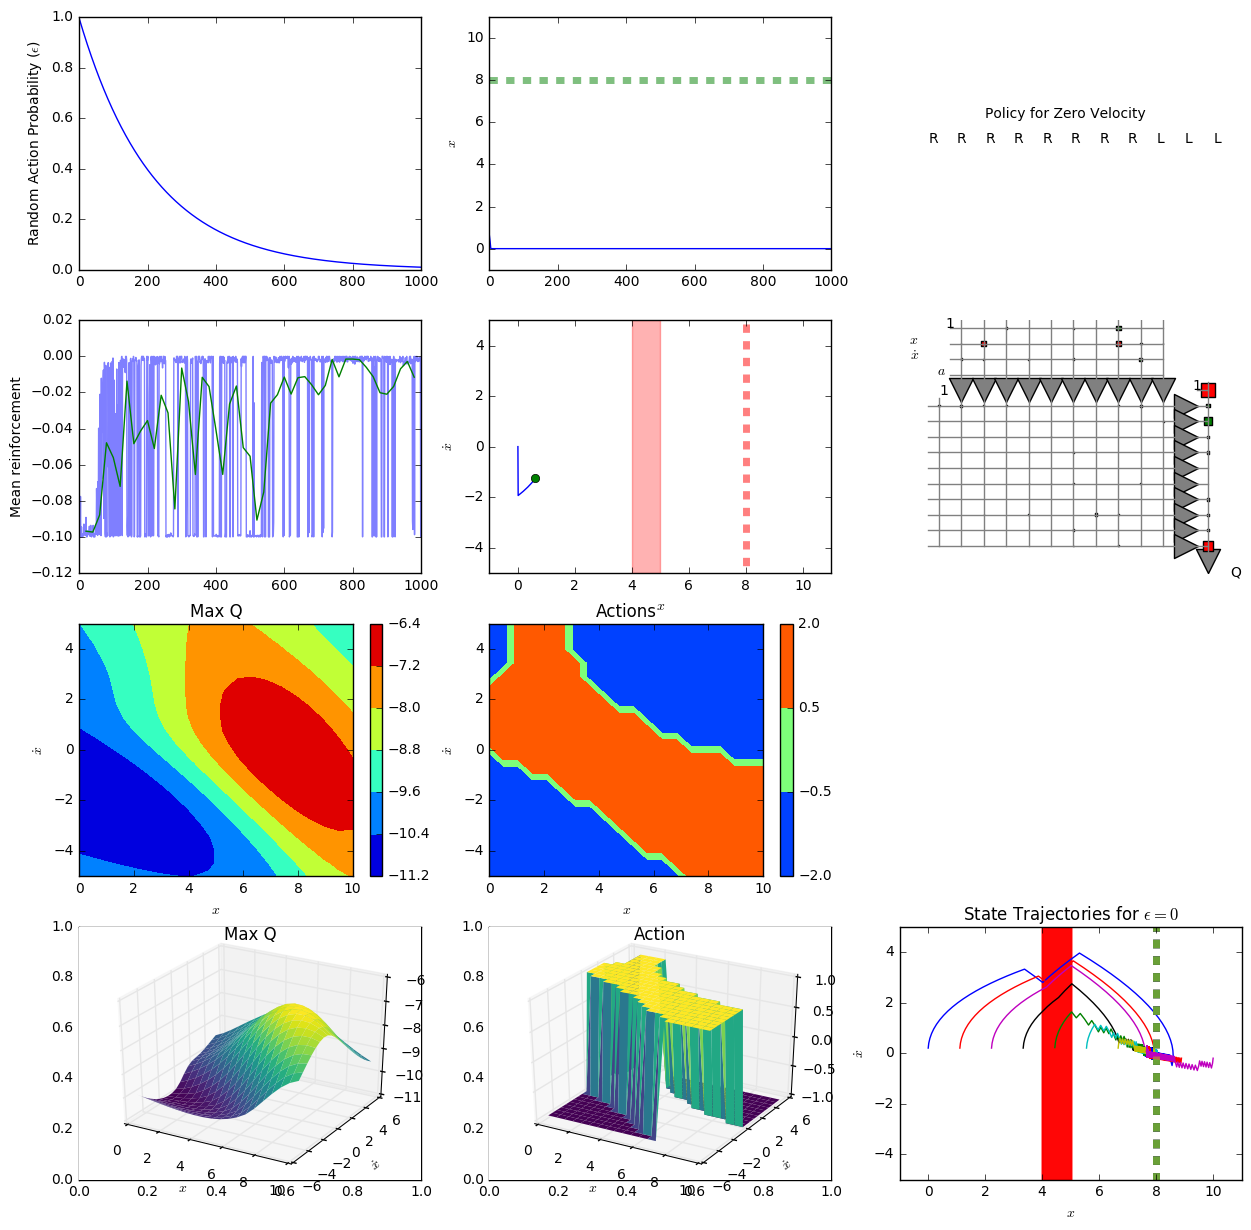

In [30]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal  = 8
for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    ns = 2
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
        testIt(qnet,10,500,goal)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

## Analysis

Following are the observations made.
* It's clearly seen from the State Trahectories graph that the velocity of the marble increase in the area of friction and that it reach the goal easily.
* The system also learns fast as shown in the reinforcement graph. 